# Thai Dengue EDA 

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('dengue-2013-2023.csv')
print(df.head())

  Disease  Year PROVINCE  Week_no  Count
0  Dengue  2013  Bangkok        1    351
1  Dengue  2013  Bangkok        2    399
2  Dengue  2013  Bangkok        3    300
3  Dengue  2013  Bangkok        4    280
4  Dengue  2013  Bangkok        5    262


### Preprocessing

In [17]:
from sklearn.preprocessing import LabelEncoder

# Remove disease column
scaled_df = df.copy()
scaled_df = scaled_df[['Year', 'PROVINCE', 'Week_no', 'Count']]
# df.head()

# Encode categorical variable
province_le = LabelEncoder()
scaled_df['PROVINCE'] = province_le.fit_transform(scaled_df['PROVINCE'])
# df.head()

# Separate features and target
X = scaled_df[['Year', 'PROVINCE', 'Week_no']]
y = scaled_df['Count']


In [19]:
province_code_mapping = dict(zip(province_le.transform(province_le.classes_), province_le.classes_))
print(province_code_mapping)

{0: 'Amnat Charoen', 1: 'Ang Thong', 2: 'Bangkok', 3: 'Bueng Kan', 4: 'Buriram', 5: 'Chachoengsao', 6: 'Chainat', 7: 'Chaiyaphum', 8: 'Chanthaburi', 9: 'Chiang Mai', 10: 'Chiang Rai', 11: 'Chonburi', 12: 'Chumphon', 13: 'Kalasin', 14: 'Kamphaeng Phet', 15: 'Kanchanaburi', 16: 'Khon Kaen', 17: 'Krabi', 18: 'Lampang', 19: 'Lamphun', 20: 'Loei', 21: 'Lopburi', 22: 'Mae Hong Son', 23: 'Maha Sarakham', 24: 'Mukdahan', 25: 'Nakhon Nayok', 26: 'Nakhon Pathom', 27: 'Nakhon Phanom', 28: 'Nakhon Ratchasima', 29: 'Nakhon Sawan', 30: 'Nakhon Si Thammarat', 31: 'Nan', 32: 'Narathiwat', 33: 'Nong Bua Lamphu', 34: 'Nong Khai', 35: 'Nonthaburi', 36: 'Pathum Thani', 37: 'Pattani', 38: 'Phang Nga', 39: 'Phatthalung', 40: 'Phayao', 41: 'Phetchabun', 42: 'Phetchaburi', 43: 'Phichit', 44: 'Phitsanulok', 45: 'Phra Nakhon Si Ayutthaya', 46: 'Phrae', 47: 'Phuket', 48: 'Prachinburi', 49: 'Prachuap Khiri Khan', 50: 'Ranong', 51: 'Ratchaburi', 52: 'Rayong', 53: 'Roi Et', 54: 'Sa Kaeo', 55: 'Sakon Nakhon', 56: 'S

### 1. Filtering Method: Correlation Matrix
Remove highly correlated features

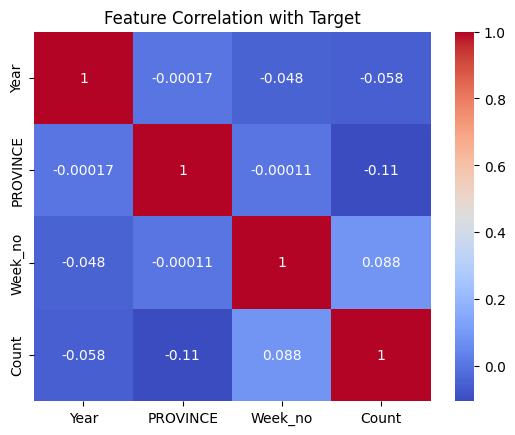

In [25]:
# Correlation matrix
corr = scaled_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()


### 2. Wrapper Method: Recursive Feature Elimination (RFE)
Trains model, removes least important feature iteratively

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(model, n_features_to_select=2)
rfe.fit(X, y)

print("Selected Features:", X.columns[rfe.support_].tolist())
print("Feature Ranking:", rfe.ranking_)


Selected Features: ['Year', 'Week_no']
Feature Ranking: [1 2 1]


### 3. Embedded Method: Lasso Regression
Drives less important feature coefficients to zero

In [23]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=3).fit(X, y)
print("Feature Coefficients:", dict(zip(X.columns, lasso.coef_)))

Feature Coefficients: {'Year': -0.6747461688779467, 'PROVINCE': -0.23806149937073626, 'Week_no': 0.28467886120916036}


### 4. Embedded Method: Tree-based Feature Importance

In [33]:
from xgboost import XGBRegressor
import numpy as np

model = XGBRegressor()
model.fit(X, y)

importances = model.feature_importances_
for col, val in zip(X.columns, importances):
    print(f"{col}: {val:.4f}")


Year: 0.3295
PROVINCE: 0.3793
Week_no: 0.2911


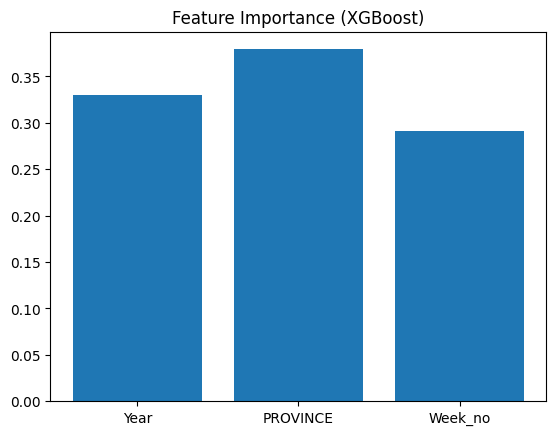

In [34]:
plt.bar(X.columns, importances)
plt.title("Feature Importance (XGBoost)")
plt.show()


## Machine Learning Model

### Model 1: Count Prediction Using Autoencoder
The idea is that, we take 3 features `Year`, `PROVINCE`, `Week_no` as **Encoder**'s input, LTSTM with 2/3 time steps, to learn the representation in a latent space (4/8 dimensions). The **Decoder**'s will predict the number of Count from the laten space.

In [ ]:
batch_size = 32
seq_len = TIME_STEPS
n_features = 4
embedding_dim = 64

In [2]:
from torch import nn

class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=4):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):  # x: (batch, seq_len, n_features)
        x, _ = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n[-1]  # shape: (batch, embedding_dim)

In [3]:
from torch import nn

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=4, n_features=3):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features

        # self.rnn1 = nn.LSTM(
        #     input_size=input_dim,
        #     hidden_size=input_dim,
        #     num_layers=1,
        #     batch_first=True
        # )

        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):  # x: (batch, input_dim)
        # Expand latent vector across time steps
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)  # (batch, seq_len, input_dim)

        # x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)

        return self.output_layer(x)  # (batch, seq_len, n_features)
